开始运行联合敏感度分析模拟（同时考虑恶意比例和 phase_switch_round）...


Simulation Rounds: 100%|██████████| 90/90 [01:43<00:00,  1.14s/it]



验证系统 'mal_10p_phase_1' 的委员会规模...
Verification complete.

验证系统 'mal_10p_phase_5' 的委员会规模...
Verification complete.

验证系统 'mal_10p_phase_10' 的委员会规模...
Verification complete.

验证系统 'mal_10p_phase_15' 的委员会规模...
Verification complete.

验证系统 'mal_10p_phase_20' 的委员会规模...
Verification complete.

验证系统 'mal_10p_phase_25' 的委员会规模...
Verification complete.

验证系统 'mal_10p_phase_30' 的委员会规模...
Verification complete.

验证系统 'mal_10p_phase_60' 的委员会规模...
Verification complete.

验证系统 'mal_10p_phase_80' 的委员会规模...
Verification complete.

验证系统 'mal_15p_phase_1' 的委员会规模...
Verification complete.

验证系统 'mal_15p_phase_5' 的委员会规模...
Verification complete.

验证系统 'mal_15p_phase_10' 的委员会规模...
Verification complete.

验证系统 'mal_15p_phase_15' 的委员会规模...
Verification complete.

验证系统 'mal_15p_phase_20' 的委员会规模...
Verification complete.

验证系统 'mal_15p_phase_25' 的委员会规模...
Verification complete.

验证系统 'mal_15p_phase_30' 的委员会规模...
Verification complete.

验证系统 'mal_15p_phase_60' 的委员会规模...
Verification complete.

验证系统 'mal_15p_pha

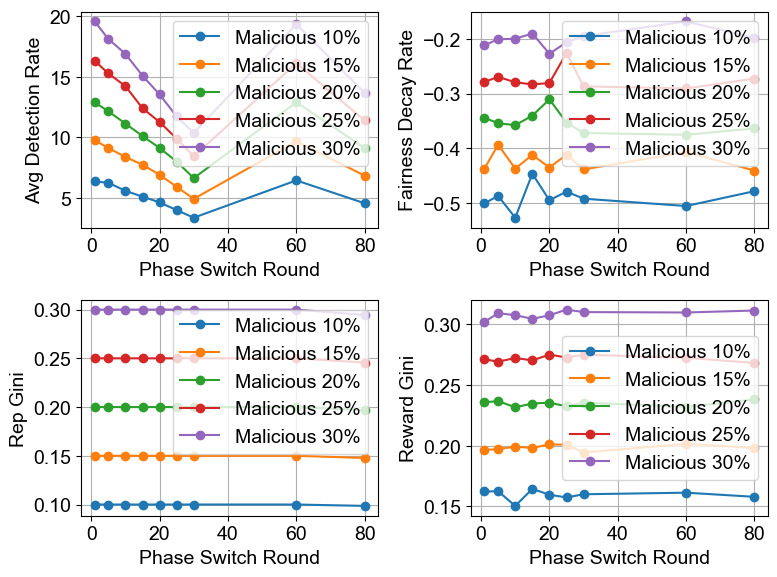


所有联合敏感度分析模拟、报告生成及可视化完毕。


In [7]:
import numpy as np
import logging
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import pandas as pd
import os
import random

# -------------------- 日志配置 --------------------
logger = logging.getLogger()
# logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# -------------------- 绘图字体配置 --------------------
font = {'family': 'Arial', 'weight': 'normal', 'size': 14}
plt.rc('font', **font)

# -------------------- Utility Functions --------------------
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def gini(x):
    x = np.sort(x)
    n = len(x)
    if n == 0 or np.sum(x) == 0:
        return 0.0
    cumx = np.cumsum(x, dtype=float)
    return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def jain_fairness(x):
    x = np.array(x)
    if np.sum(x) == 0:
        return 0.0
    return (np.sum(x)**2) / (len(x) * np.sum(x**2) + 1e-8) * sigmoid(np.mean(x)/10)

# -------------------- Node 类 --------------------
class Node:
    def __init__(self, node_id, init_stake=100, init_rep=100):
        self.id = node_id
        self.stake = init_stake
        self.reputation = init_rep
        self.total_reward = 0
        self.violations = 0
        self.participation = 0
        self.contrib_history = []
        self.cooldown = 0
        self.last_violation_round = -np.inf
        self.consecutive_committee = 0
        self.total_committee = 0
        self.identity_verified = True

    def update_committee_status(self, is_in_committee):
        if is_in_committee and self.cooldown <= 0:
            self.consecutive_committee += 1
            self.total_committee += 1
            self.cooldown = 3  # 冷却期设为 3 轮
            logger.debug(f"Node {self.id} selected for committee. Cooldown set to {self.cooldown}.")
        else:
            if is_in_committee and self.cooldown > 0:
                logger.debug(f"Node {self.id} attempted to join committee but is in cooldown.")
            self.consecutive_committee = 0
        if self.cooldown > 0:
            self.cooldown = max(0, self.cooldown - 1)
            logger.debug(f"Node {self.id} cooldown decremented to {self.cooldown}.")

    def act_normal(self):
        base = np.random.normal(7, 1)
        fluctuation = np.random.choice([0.8, 1.0, 1.2], p=[0.2, 0.6, 0.2])
        contrib = max(0, base * fluctuation)
        self.contrib_history.append(contrib)
        logger.debug(f"Node {self.id} acted normally with contribution {contrib:.2f}.")
        return contrib

    def act_malicious(self, phase):
        try:
            phase = int(phase)
            if phase == 1:
                contrib = max(9.5, np.random.normal(9.8, 0.3))
            elif phase == 2:
                contrib = 0
            elif phase == 3:
                contrib = np.random.choice([10, 0], p=[0.6, 0.4])
            else:
                raise ValueError(f"Invalid attack phase: {phase}")
        except Exception as e:
            logger.error(f"Node {self.id} attack phase error: {str(e)}")
            contrib = 0
        self.contrib_history.append(contrib)
        logger.debug(f"Node {self.id} acted maliciously with contribution {contrib}.")
        return contrib

# -------------------- FLSystem 类 --------------------
class FLSystem:
    def __init__(self, 
                 num_nodes=100,
                 base_reward=1000,
                 committee_size=10,
                 stake_weight=0.4,
                 rep_exponent=0.5,
                 init_stake=100,
                 init_rep=100,
                 malicious_ratio=0.1,
                 phase_switch_round=25,
                 sybil_resistance=False):
        self.sybil_resistance = sybil_resistance
        self.nodes = [Node(i+1, init_stake, init_rep) for i in range(num_nodes)]
        self.malicious_nodes = self._init_malicious_nodes(malicious_ratio)
        self.base_reward = base_reward
        self.malicious_ratio = malicious_ratio
        self.committee_size = committee_size
        self.stake_weight = stake_weight
        self.rep_exponent = rep_exponent
        self.phase_switch_round = phase_switch_round
        self.current_round = 0
        self.reputation_history = []
        self.reward_history = []
        self.gini_history = []
        self.fairness_history = []
        self.detection_history = []
        self.committee_history = []
        self.penalty_history = []

    def _init_malicious_nodes(self, ratio):
        num_malicious = int(len(self.nodes) * ratio)
        malicious = self.nodes[:num_malicious]
        logger.info(f"Initialized {num_malicious} malicious nodes (ratio={ratio}).")
        return malicious

    def _dynamic_malicious_threshold(self):
        contribs = [node.contrib_history[-1] if node.contrib_history else 0 for node in self.nodes]
        percentile_30 = np.percentile(contribs, 30)
        threshold = percentile_30 * 0.7 + 1e-8
        logger.debug(f"Dynamic malicious threshold calculated: {threshold:.4f}")
        return threshold

    def select_committee(self, num_strata=3):
        sorted_nodes = sorted(self.nodes, key=lambda x: x.reputation, reverse=True)
        strata_size = len(sorted_nodes) // num_strata
        strata = [sorted_nodes[i*strata_size : (i+1)*strata_size] for i in range(num_strata)]
        if len(sorted_nodes) % num_strata != 0:
            strata[-1].extend(sorted_nodes[num_strata*strata_size:])
            logger.debug("Added remaining nodes to last stratum.")

        selected = []
        quotas = [self.committee_size // num_strata] * num_strata
        remaining_quota = self.committee_size - sum(quotas)
        for i in range(remaining_quota):
            quotas[i % num_strata] += 1
        logger.debug(f"Final quotas per stratum: {quotas}")

        for idx, (stratum, quota) in enumerate(zip(strata, quotas)):
            candidates = [node for node in stratum if node.cooldown <= 0]
            eligible_count = len(candidates)
            logger.debug(f"Stratum {idx+1}: {eligible_count} eligible candidates.")
            if eligible_count == 0:
                continue
            select_count = min(quota, eligible_count)
            select_count = max(1, select_count)
            if eligible_count == 1:
                probabilities = [1.0]
            else:
                reputation_scores = np.array([node.reputation for node in candidates], dtype=float)
                probabilities = softmax(reputation_scores ** self.rep_exponent)
            selected_nodes = np.random.choice(candidates, size=select_count, p=probabilities, replace=False)
            selected.extend(selected_nodes)
            logger.debug(f"Stratum {idx+1}: Selected {select_count} nodes.")

        if len(selected) < self.committee_size:
            remaining_quota = self.committee_size - len(selected)
            eligible_nodes = [node for node in self.nodes if node.cooldown <= 0 and node not in selected]
            eligible_count = len(eligible_nodes)
            logger.debug(f"Remaining eligible nodes for redistribution: {eligible_count}.")
            if eligible_count >= remaining_quota:
                if eligible_count == 1:
                    probabilities = [1.0]
                else:
                    reputation_scores = np.array([node.reputation for node in eligible_nodes], dtype=float)
                    probabilities = softmax(reputation_scores ** self.rep_exponent)
                selected_nodes = np.random.choice(eligible_nodes, size=remaining_quota, p=probabilities, replace=False)
                selected.extend(selected_nodes)
                logger.debug(f"Redistributed and selected {remaining_quota} additional nodes.")
            elif eligible_count > 0:
                selected.extend(eligible_nodes)
                logger.warning(f"Only {eligible_count} eligible nodes available; committee size reduced.")

        if len(selected) < self.committee_size:
            logger.warning(f"Unable to fill committee to desired size of {self.committee_size}. Only {len(selected)} members selected.")
        else:
            logger.debug(f"Committee selected with {len(selected)} members.")

        for node in self.nodes:
            node.update_committee_status(node in selected)
        self.committee_history.append([node.id for node in selected])
        logger.info(f"Round {self.current_round + 1}: Committee selected with {len(selected)} members.")
        return selected

    def calculate_reward(self, node, avg_rep):
        avg_stake = np.mean([n.stake for n in self.nodes])
        effective_stake = min(node.stake, avg_stake * 3)
        hist_contrib = sum(c * (0.9**t) for t, c in enumerate(reversed(node.contrib_history[-5:])))
        alpha = sigmoid((avg_rep - 100)/50) * self.stake_weight
        beta = 1 - alpha
        diversity_bonus = jain_fairness([n.reputation for n in self.nodes])
        committee_reward = 40 * diversity_bonus if node.id in self.committee_history[-1] else 0
        total = (alpha * self.base_reward * (effective_stake / (sum(n.stake for n in self.nodes) + 1e-8)) +
                 beta * self.base_reward * (hist_contrib / (sum(n.contrib_history[-1] for n in self.nodes) + 1e-8)) +
                 committee_reward) * diversity_bonus
        return max(total, 0)

    def update_reputation(self, node, contribution):
        age_factor = 1 - 1/(1 + node.participation/100)
        delta = 0.88 + 0.07 * age_factor
        contrib_base = 0
        contrib_thre = 10
        contrib_quality = sigmoid((contribution - contrib_base) / (contrib_thre - contrib_base))
        if len(node.contrib_history) >= 5:
            stability = 1 - np.std(node.contrib_history[-5:]) / 5
        else:
            stability = 0.8
        new_rep = (node.reputation * delta + contrib_quality * 50 + stability * 30)
        rep_cap = 500 if self.current_round > 50 else 300
        return np.clip(new_rep, 0, rep_cap)

    def detect_malicious(self, node):
        if len(node.contrib_history) < 5:
            return False
        window = node.contrib_history[-5:]
        avg = np.mean(window)
        std = np.std(window)
        threshold = self._dynamic_malicious_threshold()
        condition1 = avg < threshold * 0.7
        condition2 = std < threshold * 0.4
        prev_avg = np.mean(node.contrib_history[-10:-5]) if len(node.contrib_history) >= 10 else 7
        condition3 = abs(avg - prev_avg) > 5
        is_malicious = (condition1 and condition2) or condition3
        logger.debug(f"Node {node.id} detection: Condition1={condition1}, Condition2={condition2}, Condition3={condition3} -> {is_malicious}")
        return is_malicious

    def run_round(self):
        base_phase = 1 if self.current_round < self.phase_switch_round else 2
        phase_variation = int(self.current_round/30) % 2
        attack_phase = min(base_phase + phase_variation, 3)
        logger.info(f"Round {self.current_round + 1}: Attack Phase {attack_phase}")
        contributions = []
        for node in self.nodes:
            if node in self.malicious_nodes:
                contrib = node.act_malicious(attack_phase)
            else:
                contrib = node.act_normal()
            contributions.append(contrib)
        self.committee = self.select_committee()
        avg_rep = np.mean([n.reputation for n in self.nodes])
        rewards = []
        detected = 0
        penalties = []
        for node, contrib in zip(self.nodes, contributions):
            if self.detect_malicious(node):
                penalty = min(0.3 * node.reputation + 0.1 * node.stake, node.reputation * 0.5)
                penalties.append(penalty)
                node.reputation -= penalty
                node.violations += 1
                detected += 1
                logger.debug(f"Node {node.id} detected as malicious. Penalty applied: {penalty:.2f}")
            else:
                node.reputation = self.update_reputation(node, contrib)
                logger.debug(f"Node {node.id} reputation updated to {node.reputation:.2f}")
            reward = self.calculate_reward(node, avg_rep)
            node.total_reward += reward
            rewards.append(reward)
            logger.debug(f"Node {node.id} received reward: {reward:.2f}")
            node.participation += 1
        self.penalty_history.append(penalties)
        self.reputation_history.append([n.reputation for n in self.nodes])
        self.reward_history.append(rewards)
        self.gini_history.append(gini(rewards))
        self.fairness_history.append(jain_fairness(rewards))
        self.detection_history.append(detected)
        self.current_round += 1
        logger.info(f"Round {self.current_round}: Detected {detected} malicious nodes.")

# -------------------- 可视化模块 --------------------
# def plot_metrics(system, label="System"):
#     if not system.reward_history:
#         print("警告：无奖励数据可供可视化")
#         return
#     rewards = np.array(system.reward_history)
#     rounds = np.arange(rewards.shape[0])
#     num_nodes = rewards.shape[1]
#     malicious_ids = [n.id-1 for n in system.malicious_nodes] if system.malicious_nodes else []
#     honest_ids = [i for i in range(num_nodes) if i not in malicious_ids]
#     for node_id in range(num_nodes):
#         color = 'tomato' if node_id in malicious_ids else 'skyblue'
#         alpha = 0.15 if node_id in malicious_ids else 0.08
#         plt.plot(rounds, rewards[:, node_id], color=color, alpha=alpha, linewidth=0.6, zorder=1)
#     if malicious_ids:
#         malicious_avg = np.mean(rewards[:, malicious_ids], axis=1)
#         malicious_q1 = np.percentile(rewards[:, malicious_ids], 25, axis=1)
#         malicious_q3 = np.percentile(rewards[:, malicious_ids], 95, axis=1)
#     else:
#         malicious_avg = np.array([])
#         malicious_q1 = np.array([])
#         malicious_q3 = np.array([])
#     honest_avg = np.mean(rewards[:, honest_ids], axis=1)
#     honest_q1 = np.percentile(rewards[:, honest_ids], 25, axis=1)
#     honest_q3 = np.percentile(rewards[:, honest_ids], 95, axis=1)
#     plt.plot(rounds, honest_avg, color='dodgerblue', linewidth=3, linestyle='-', 
#              label=f'Honest Avg (Final: {honest_avg[-1]:.1f})', zorder=4)
#     if len(malicious_avg) > 0:
#         plt.plot(rounds, malicious_avg, color='crimson', linewidth=3, linestyle='--', 
#                  label=f'Malicious Avg (Final: {malicious_avg[-1]:.1f})', zorder=5)
#     plt.fill_between(rounds, honest_q1, honest_q3, color='skyblue', alpha=0.3, label='Honest IQR')
#     if len(malicious_avg) > 0:
#         plt.fill_between(rounds, malicious_q1, malicious_q3, color='lightcoral', alpha=0.3, label='Malicious IQR')
#     plt.xlabel('Round', fontsize=14)
#     plt.ylabel('Reward Value', fontsize=14)
#     plt.grid(True, linestyle='--', alpha=0.6)
#     legend_elements = [
#         Patch(facecolor='skyblue', alpha=0.3, label='Honest IQR'),
#         Line2D([0], [0], color='dodgerblue', lw=2, label='Honest Average')
#     ]
#     if len(malicious_avg) > 0:
#         legend_elements.extend([
#             Patch(facecolor='lightcoral', alpha=0.3, label='Malicious IQR'),
#             Line2D([0], [0], color='crimson', lw=2, ls='--', label='Malicious Average')
#         ])
#     legend_elements.append(Line2D([0], [0], color='skyblue', alpha=0.3, lw=1, label='Honest Traces'))
#     if len(malicious_avg) > 0:
#         legend_elements.append(Line2D([0], [0], color='tomato', alpha=0.3, lw=1, label='Malicious Traces'))
#     plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.25, 0.35),
#                ncol=1, frameon=False, fontsize=12)
#     plt.tight_layout()
#     plt.show()

# -------------------- 报告生成模块 --------------------
def generate_simulation_report(system, filename):
    if not filename.lower().endswith('.csv'):
        raise ValueError("Filename must end with '.csv'")
    base, ext = os.path.splitext(filename)
    round_metrics_filename = f"{base}_round_metrics.csv"
    node_summary_filename = f"{base}_node_summary.csv"
    rounds = list(range(1, system.current_round + 1))
    gini_list = system.gini_history
    fairness_list = system.fairness_history
    detected = system.detection_history
    penalties = system.penalty_history
    committee_history = system.committee_history
    total_penalties = [sum(p) for p in penalties]
    committee_members = [', '.join(map(str, committee)) for committee in committee_history]
    round_metrics_df = pd.DataFrame({
        'Round': rounds,
        'Gini Coefficient': gini_list,
        'Fairness Index': fairness_list,
        'Detected Malicious Nodes': detected,
        'Total Penalties': total_penalties,
        'Committee Members': committee_members
    })
    node_ids = [node.id for node in system.nodes]
    stakes = [node.stake for node in system.nodes]
    final_reputations = [node.reputation for node in system.nodes]
    total_rewards = [node.total_reward for node in system.nodes]
    violations = [node.violations for node in system.nodes]
    participation = [node.participation for node in system.nodes]
    total_committee = [node.total_committee for node in system.nodes]
    cooldowns = [node.cooldown for node in system.nodes]
    node_summary_df = pd.DataFrame({
        'Node ID': node_ids,
        'Stake': stakes,
        'Final Reputation': final_reputations,
        'Total Reward': total_rewards,
        'Violations': violations,
        'Participation Count': participation,
        'Total Committee Memberships': total_committee,
        'Current Cooldown': cooldowns
    })
    try:
        round_metrics_df.to_csv(round_metrics_filename, index=False)
        print(f"Round metrics saved to {round_metrics_filename}")
        node_summary_df.to_csv(node_summary_filename, index=False)
        print(f"Node summary saved to {node_summary_filename}")
    except Exception as e:
        print(f"Error saving reports: {e}")
        raise e
    return round_metrics_df, node_summary_df

# -------------------- 联合敏感度分析主程序 --------------------
if __name__ == "__main__":
    np.random.seed(1411758002)
    random.seed(1411758002)
    
    # 模拟参数设置
    N = 100                # 节点数量
    CS = 5                 # 委员会规模
    Base = 1200            # 基础奖励
    rep_exponent = 0.5
    stake_weight = 0.4
    R = 90                 # 模拟轮次
    
    # 定义多个恶意比例和 phase_switch_round 取值
    malicious_ratios = [0.10, 0.15, 0.20, 0.25, 0.30]
    phase_values = [1, 5, 10, 15, 20, 25, 30, 60, 80]
    
    # 建立参数网格，组合成多个系统实例
    systems = {}
    for ratio in malicious_ratios:
        for phase in phase_values:
            key = f"mal_{int(ratio*100)}p_phase_{phase}"
            systems[key] = FLSystem(
                num_nodes=N,
                base_reward=Base,
                committee_size=CS,
                stake_weight=stake_weight,
                rep_exponent=rep_exponent,
                malicious_ratio=ratio,
                phase_switch_round=phase
            )
    
    # 运行模拟，每个系统运行 R 轮
    print("开始运行联合敏感度分析模拟（同时考虑恶意比例和 phase_switch_round）...")
    for _ in tqdm(range(R), desc="Simulation Rounds"):
        for key in systems:
            systems[key].run_round()
    
    # 创建结果存储文件夹
    folderpath = "./exp_res/joint_sensitivity/"
    if not os.path.exists(folderpath):
        os.makedirs(folderpath)
    
    # 生成各系统报告和验证委员会规模
    def verify_committee_size(system, expected_size=CS):
        for round_num, committee in enumerate(system.committee_history, 1):
            if len(committee) != expected_size:
                print(f"Round {round_num}: Committee size {len(committee)} does not match expected {expected_size}.")
        print("Verification complete.")
    
    for key in systems:
        filename = f"{folderpath}simulation_report_N{N}_{key}.csv"
        # generate_simulation_report(systems[key], filename=filename)
        print(f"\n验证系统 '{key}' 的委员会规模...")
        verify_committee_size(systems[key], expected_size=CS)
    
    # -------------------- 指标计算 --------------------
    joint_results = []
    for key, system in systems.items():
        avg_detection_rate = np.mean(system.detection_history)
        if system.fairness_history[0] != 0:
            fairness_decay = (system.fairness_history[0] - system.fairness_history[-1]) / system.fairness_history[0]
        else:
            fairness_decay = 0
        final_reputations = system.reputation_history[-1]
        final_rewards = system.reward_history[-1]

        rep_gini = gini(final_reputations)
        reward_gini = gini(final_rewards)
        participation_counts = [node.participation for node in system.nodes]
        committee_participation_var = np.var(participation_counts)
        # 解析 key 中的参数信息
        parts = key.split('_')
        mal_ratio = int(parts[1].replace("p", "")) / 100.0
        phase_val = int(parts[-1])
        joint_results.append({
            "malicious_ratio": mal_ratio,
            "phase_switch_round": phase_val,
            "avg_detection_rate": avg_detection_rate,
            "fairness_decay_rate": fairness_decay,
            "rep_gini": rep_gini,
            "reward_gini": reward_gini,
            "committee_participation_var": committee_participation_var
        })
    
    results_df = pd.DataFrame(joint_results)
    print("\n联合敏感度分析结果：")
    print(results_df)
    results_filename = f"{folderpath}joint_sensitivity_analysis_results.csv"
    results_df.to_csv(results_filename, index=False)
    print(f"联合敏感度分析结果保存至 {results_filename}")
    
    # -------------------- 可视化比较 --------------------
    # 绘制不同恶意比例下，phase_switch_round 对 avg_detection_rate 的影响
    fig, axes = plt.subplots(2, 2, figsize=(8, 6))
    
    for ratio in malicious_ratios:
        sub_df = results_df[results_df["malicious_ratio"] == ratio]
        axes[0, 0].plot(sub_df["phase_switch_round"], sub_df["avg_detection_rate"], marker='o', label=f"Malicious {int(ratio*100)}%")
    axes[0, 0].set_xlabel("Phase Switch Round")
    axes[0, 0].set_ylabel("Avg Detection Rate")
    # axes[0, 0].set_title("Detection Rate vs. Phase Switch")
    axes[0, 0].grid(True)
    axes[0, 0].legend()
    
    # 绘制不同恶意比例下，phase_switch_round 对 fairness_decay_rate 的影响
    for ratio in malicious_ratios:
        sub_df = results_df[results_df["malicious_ratio"] == ratio]
        axes[0, 1].plot(sub_df["phase_switch_round"], sub_df["fairness_decay_rate"], marker='o', label=f"Malicious {int(ratio*100)}%")
    axes[0, 1].set_xlabel("Phase Switch Round")
    axes[0, 1].set_ylabel("Fairness Decay Rate")
    # axes[0, 1].set_title("Fairness Decay vs. Phase Switch")
    axes[0, 1].grid(True)
    axes[0, 1].legend()
    
    # 3. 声誉基尼系数 (rep_gini)
    for ratio in malicious_ratios:
        sub_df = results_df[results_df["malicious_ratio"] == ratio]
        axes[1, 0].plot(sub_df["phase_switch_round"], sub_df["rep_gini"], marker='o', label=f"Malicious {int(ratio*100)}%")
    axes[1, 0].set_xlabel("Phase Switch Round")
    axes[1, 0].set_ylabel("Rep Gini")
    # axes[1, 0].set_title("Rep Gini vs. Phase Switch")
    axes[1, 0].grid(True)
    axes[1, 0].legend()
    
    # 4. 奖励基尼系数 (reward_gini)
    for ratio in malicious_ratios:
        sub_df = results_df[results_df["malicious_ratio"] == ratio]
        axes[1, 1].plot(sub_df["phase_switch_round"], sub_df["reward_gini"], marker='o', label=f"Malicious {int(ratio*100)}%")
    axes[1, 1].set_xlabel("Phase Switch Round")
    axes[1, 1].set_ylabel("Reward Gini")
    # axes[1, 1].set_title("Rep Gini vs. Phase Switch")
    axes[1, 1].grid(True)
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # 生成各系统奖励分布图（可选）
    # print("\n生成各系统奖励分布图表...")
    # for key in systems:
    #     print(f"生成 {key} 的奖励分布图...")
    #     plot_metrics(systems[key], label=key)
    
    print("\n所有联合敏感度分析模拟、报告生成及可视化完毕。")
